# Zomato Delivery Operations Analytics

Source: https://www.kaggle.com/datasets/saurabhbadole/zomato-delivery-operations-analytics-dataset

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler

# Label encoding
from sklearn.preprocessing import LabelEncoder

# split train test
from re import X
from sklearn.model_selection import train_test_split

# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Libraries for modelling
from sklearn.linear_model import Ridge, Lasso
#from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, KFold

# Model Evaluation with metrics: RMSE, MAE & MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
deliv_df = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE BOOTCAMP/FINAL PROJECT/Zomato Dataset.csv')
print('Total Baris : ', deliv_df.shape[0])
print('Total Kolom : ', deliv_df.shape[1])
deliv_df.head()

Total Baris :  45584
Total Kolom :  20


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41



Features:
*   ID: Unique identifier for each delivery.
*Delivery_person_ID: Unique identifier for each delivery person.
*Delivery_person_Age: Age of the delivery person.
*Delivery_person_Ratings: Ratings assigned to the delivery person.
*Restaurant_latitude: Latitude of the restaurant.
*Restaurant_longitude: Longitude of the restaurant.
*Delivery_location_latitude: Latitude of the delivery location.
*Delivery_location_longitude: Longitude of the delivery location.
*Order_Date: Date of the order.
*Time_Ordered: Time the order was placed.
*Time_Order_picked: Time the order was picked up for delivery.
*Weather_conditions: Weather conditions at the time of delivery.
*Road_traffic_density: Density of road traffic during delivery.
*Vehicle_condition: Condition of the delivery vehicle.
*Type_of_order: Type of order (e.g., dine-in, takeaway, delivery).
*Type_of_vehicle: Type of vehicle used for delivery.
*Multiple_deliveries: Indicator of whether multiple deliveries were made in the same trip.
*Festival: Indicator of whether the delivery coincided with a festival.
*City: City where the delivery took place.
*Time_taken (min): Time taken for delivery in minutes.



# Data Cleaning and Manipulation

In [ ]:
# Informasi Data
deliv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           44968 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

Observasi:<br>


1.   Dataset memiliki 20 kolom dan 45584 baris
2.   Tipe data yang masih belum sesuai: `Order_Date`, `Time_ordered` dan `Time_Order_picked`
3. Terdapat missing value di beberapa kolom (Jumlah data kolom < Jumlah baris), akan dilakukan pengolahan lebih lanjut pada next proses.


In [ ]:
# Ubah data type kolom Order_Date
deliv_df['Order_Date'] = pd.to_datetime(deliv_df['Order_Date'], format='%d-%m-%Y')

In [ ]:
# Drop Kolom ID dan Person ID karena tidak mengandung informasi yang relevan untuk dilakukan pemodelan ML atau analisis data
deliv_df = deliv_df.drop(columns=['ID','Delivery_person_ID'])

In [ ]:
# Check missing value
deliv_null = deliv_df.isnull().sum().reset_index() # membuat variabel baru
deliv_null.columns = ['feature','missing_value'] # menambahkan kolom
deliv_null['percentage'] = round((deliv_null['missing_value']/len(deliv_df))*100,2) # menghitung percentage
deliv_null = deliv_null.sort_values('percentage', ascending=False).reset_index(drop=True)
deliv_null = deliv_null[deliv_null['percentage']>0] # menampilkan features yang hanya terdapat missing value
deliv_null

,feature,missing_value,percentage
0,Delivery_person_Ratings,1908,4.19
1,Delivery_person_Age,1854,4.07
2,Time_Orderd,1731,3.80
3,City,1200,2.63
4,multiple_deliveries,993,2.18
5,Weather_conditions,616,1.35
6,Road_traffic_density,601,1.32
7,Festival,228,0.50


Terdapat 8 kolom yang terdapat Missing Value. Handling Missing Value:
* Missing value pada kolom kategorikal -> replace dengan Modus (Karena jumlah <5%)
* Missing value pada  kolom `Delivery_person_Ratings` dan `Delivery_person_Age` -> replace dengan nilai Median
* Missing value pada kolom `Time_Order` akan didrop, karena rencananya akan dibuat kolom baru hasil pengurangan `Time_order_picked` dengan `Time_order`untuk menghitung time_preparation. Sehingga memerlukan nilai yang tepat, makan akan didrop untuk menghindari kesalahan pada feature baru.

In [ ]:
# Handling missing value
# Untuk kategorikal data (City, multiple_deliveries, Weather_conditions, Road_traffic_density, Festival) akan direplace dengan modus karena jumlahnya <5%
for col in ['City','multiple_deliveries','Weather_conditions','Road_traffic_density','Festival']:
  print(f"Mode from {col}: {deliv_df[col].mode()[0]}")


Mode from City: Metropolitian
Mode from multiple_deliveries: 1.0
Mode from Weather_conditions: Fog
Mode from Road_traffic_density: Low
Mode from Festival: No


In [ ]:
# Replace missing value dengan Modus
deliv_df['City'].fillna(deliv_df['City'].mode()[0], inplace=True)
deliv_df['multiple_deliveries'].fillna(deliv_df['multiple_deliveries'].mode()[0], inplace=True)
deliv_df['Weather_conditions'].fillna(deliv_df['Weather_conditions'].mode()[0], inplace=True)
deliv_df['Road_traffic_density'].fillna(deliv_df['Road_traffic_density'].mode()[0], inplace=True)
deliv_df['Festival'].fillna(deliv_df['Festival'].mode()[0], inplace=True)

<ipython-input-52-4c41f5f61244>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliv_df['City'].fillna(deliv_df['City'].mode()[0], inplace=True)
<ipython-input-52-4c41f5f61244>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [ ]:
# Untuk kolom Age dan Ratings replace menggunakan nilai median
# Nilai median
for col in ['Delivery_person_Ratings', 'Delivery_person_Age']:
    print(f"Median from {col}: {deliv_df[col].median()}")

Median from Delivery_person_Ratings: 4.7
Median from Delivery_person_Age: 30.0


In [ ]:
# Replace
deliv_df['Delivery_person_Ratings'].fillna(deliv_df['Delivery_person_Ratings'].median(), inplace=True)
deliv_df['Delivery_person_Age'].fillna(deliv_df['Delivery_person_Age'].median(), inplace=True)

<ipython-input-14-27ebe00af231>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliv_df['Delivery_person_Ratings'].fillna(deliv_df['Delivery_person_Ratings'].median(), inplace=True)
<ipython-input-14-27ebe00af231>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [ ]:
# drop baris yang terdapat missing value pada kolom Time_Orderd
deliv_df = deliv_df.dropna(subset=['Time_Orderd'])

In [ ]:
# Lakukan re-check setelah treatment
deliv_df.isna().sum()

,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,0
Time_Order_picked,0
Weather_conditions,0


In [ ]:
# Check data type
deliv_df.dtypes

,0
Delivery_person_Age,float64
Delivery_person_Ratings,float64
Restaurant_latitude,float64
Restaurant_longitude,float64
Delivery_location_latitude,float64
Delivery_location_longitude,float64
Order_Date,datetime64[ns]
Time_Orderd,object
Time_Order_picked,object
Weather_conditions,object


In [ ]:
# Check unique value
deliv_df['Time_Orderd'].unique()

array(['21:55', '14:55', '17:30', '09:20', '19:50', '20:25', '20:30',
       '20:40', '21:15', '20:20', '22:30', '08:15', '19:30', '12:25',
       '18:35', '20:35', '23:20', '21:20', '23:35', '22:35', '23:25',
       '13:35', '21:35', '18:55', '14:15', '0.458333333', '09:45',
       '08:40', '0.958333333', '17:25', '19:45', '19:10', '10:55',
       '21:40', '0.791666667', '16:45', '11:30', '15:10', '22:45',
       '22:10', '20:45', '22:50', '17:55', '09:25', '20:15', '22:25',
       '22:40', '23:50', '15:25', '10:20', '20:55', '10:40', '15:55',
       '20:10', '12:10', '15:30', '10:35', '21:10', '20:50', '12:35',
       '0.875', '23:40', '18:15', '18:20', '11:45', '12:45', '23:30',
       '10:50', '21:25', '10:10', '17:50', '22:20', '12:40', '23:55',
       '10:25', '08:45', '23:45', '19:55', '22:15', '23:10', '09:15',
       '18:25', '18:45', '16:50', '1', '14:20', '10:15', '08:50', '0.375',
       '17:45', '16:35', '08:30', '21:45', '19:40', '14:50', '18:10',
       '12:20', '12:50',

In [ ]:
deliv_df['Time_Order_picked'].unique()

array(['22:10', '15:05', '17:40', '09:30', '20:05', '20:35', '15:10',
       '20:40', '20:50', '21:30', '20:25', '22:45', '08:30', '19:45',
       '12:30', '18:50', '23:30', '21:35', '23:45', '22:50', '22:40',
       '23:35', '13:40', '21:45', '19:10', '14:25', '11:10', '09:55',
       '08:55', '23:10', '17:30', '19:50', '19:25', '0.458333333',
       '19:15', '16:55', '11:40', '15:15', '22:55', '22:25', '20:55',
       '23:05', '0.75', '0.958333333', '09:40', '20:20', '22:35',
       '0.916666667', '23:55', '15:40', '10:30', '0.875', '10:50',
       '16:05', '20:15', '12:15', '15:45', '22:15', '10:45', '24:05:00',
       '21:25', '12:45', '21:15', '18:20', '18:25', '11:50', '12:50',
       '10:55', '21:40', '10:20', '17:55', '23:50', '12:55', '24:10:00',
       '10:40', '0.375', '20:45', '0.833333333', '23:15', '18:35',
       '22:20', '21:05', '0.708333333', '24:15:00', '21:20', '14:35',
       '10:25', '09:05', '16:50', '08:40', '23:40', '21:50', '19:55',
       '0.625', '10:35', '0

Ternyata terdapat data yang tidak sesuai dengan data waktu (data desimal) di kolom waktu order dan waktu picked, maka kita akan lakukan drop data tersebut, karena tidak mengetahui kapan waktu yang tepat.

In [ ]:
# Filter baris yang hanya mengandung ':'
deliv_df = deliv_df[deliv_df['Time_Orderd'].str.contains(':', na=False)]
deliv_df = deliv_df[deliv_df['Time_Order_picked'].str.contains(':', na=False)]

# Konversi nilai menjadi tipe datetime dengan format %H:%M
deliv_df['Time_Orderd'] = pd.to_datetime(deliv_df['Time_Orderd'], format='%H:%M', errors='coerce')
deliv_df['Time_Order_picked'] = pd.to_datetime(deliv_df['Time_Order_picked'], format='%H:%M', errors='coerce')

In [ ]:
deliv_df.dtypes

,0
Delivery_person_Age,float64
Delivery_person_Ratings,float64
Restaurant_latitude,float64
Restaurant_longitude,float64
Delivery_location_latitude,float64
Delivery_location_longitude,float64
Order_Date,datetime64[ns]
Time_Orderd,datetime64[ns]
Time_Order_picked,datetime64[ns]
Weather_conditions,object


Data type sudah sesuai

In [ ]:
deliv_df.head(10)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,1900-01-01 21:55:00,1900-01-01 22:10:00,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,1900-01-01 14:55:00,1900-01-01 15:05:00,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,1900-01-01 17:30:00,1900-01-01 17:40:00,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,1900-01-01 09:20:00,1900-01-01 09:30:00,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,1900-01-01 19:50:00,1900-01-01 20:05:00,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41
5,29.0,4.5,19.176269,72.836721,19.266269,72.926721,2022-04-02,1900-01-01 20:25:00,1900-01-01 20:35:00,Sandstorms,Jam,2,Buffet,electric_scooter,1.0,No,Metropolitian,20
6,35.0,4.0,12.311072,76.654878,12.351072,76.694878,2022-03-01,1900-01-01 14:55:00,1900-01-01 15:10:00,Windy,High,1,Meal,scooter,1.0,No,Metropolitian,33
7,33.0,4.2,18.592718,73.773572,18.702718,73.883572,2022-03-16,1900-01-01 20:30:00,1900-01-01 20:40:00,Sandstorms,Jam,2,Snack,motorcycle,1.0,No,Metropolitian,40
8,34.0,4.9,17.426228,78.407495,17.496228,78.477495,2022-03-20,1900-01-01 20:40:00,1900-01-01 20:50:00,Cloudy,Jam,0,Snack,motorcycle,1.0,No,Metropolitian,41
9,21.0,4.7,22.552672,88.352885,22.582672,88.382885,2022-02-15,1900-01-01 21:15:00,1900-01-01 21:30:00,Windy,Jam,0,Meal,motorcycle,1.0,No,Urban,15


Time_Order & Time_Order_picked akan digunakan untuk mencari feature baru yang berisi selisih waktu antara kedua feature

In [ ]:
# Check duplicate value
deliv_df.duplicated().sum()

0

tidak terdapat nilai duplicate

# Feature Engineering (Before EDA)

1. Create `order_prepare_time` : Difference between Time_Ordered and Time_Order_picked, reflecting the time taken for order preparation
2. Create `distance` : Computed using the geodesic library, this metric measures the spatial separation between
Restaurant_coordinates and Delivery_coordinates.
3. Create `day_of_week`: Extracted from Order_Date, specifying the day (Sunday/Monday/etc)
5. Create `time_category` : Time_Order grouping -> Morning (00.00-10.00), Afternoon(10.01-14.00), Evening (14.01-18.00), Night (18.01-23.59)

In [ ]:
# order_prepare_time
# Hitung selisih waktu dalam menit dan buat kolom baru
deliv_df['order_prepare_time (min)'] = deliv_df['Time_Order_picked'] - deliv_df['Time_Orderd']
deliv_df['order_prepare_time (min)'] = deliv_df['order_prepare_time (min)'].apply(lambda x: int(x.total_seconds() // 60)if pd.notna(x) else 0)

In [ ]:
deliv_df['order_prepare_time (min)'].isna().sum()

0

In [ ]:
# drop missing value untuk kolom order_prepare_time
deliv_df = deliv_df.dropna(subset=['order_prepare_time (min)'])

In [ ]:
# distance
# menggunakan geopy.distance untuk menghitung distance dari data longitude dan latitude

def calculate_distance(row):
    resto_coords = (row['Restaurant_latitude'], row['Restaurant_longitude'])
    deliv_coords = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
    return geodesic(resto_coords, deliv_coords).kilometers

deliv_df['distance'] = deliv_df.apply(calculate_distance, axis=1)

In [ ]:
# day_of_week, time_order

# Menambah kolom 'time_order' yang nilainya berasal dari kategorisasi time order
deliv_df['time_category'] = pd.cut(
    deliv_df['Time_Orderd'].dt.hour,
    bins=[-1, 10, 14, 18, 23],
    labels=['Morning', 'Afternoon', 'Evening', 'Night']
)

# Menambah kolom 'day' dengan format nama hari (Sunday, Monday, etc.)
deliv_df['day_of_week'] = deliv_df['Order_Date'].dt.strftime('%A')


In [ ]:
# drop kolom Restaurant longitude & latitude serta Delivery longituted dan latitude
deliv_df = deliv_df.drop(columns=['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'])
# drop kolom order_date, time_order dan time_order_picked
deliv_df = deliv_df.drop(columns=['Time_Orderd','Time_Order_picked'])

In [ ]:
deliv_df.head(10)

,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),order_prepare_time (min),distance,time_category,day_of_week
0,36.0,4.2,2022-02-12,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,15,10.271464,Night,Saturday
1,21.0,4.7,2022-02-13,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,10,6.229376,Afternoon,Sunday
2,23.0,4.7,2022-03-04,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,10,13.764306,Evening,Friday
3,34.0,4.3,2022-02-13,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,10,2.927795,Morning,Sunday
4,24.0,4.7,2022-02-14,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,15,19.373484,Night,Monday
5,29.0,4.5,2022-04-02,Sandstorms,Jam,2,Buffet,electric_scooter,1.0,No,Metropolitian,20,10,13.740932,Night,Saturday
6,35.0,4.0,2022-03-01,Windy,High,1,Meal,scooter,1.0,No,Metropolitian,33,15,6.205590,Afternoon,Tuesday
7,33.0,4.2,2022-03-16,Sandstorms,Jam,2,Snack,motorcycle,1.0,No,Metropolitian,40,10,16.821192,Night,Wednesday
8,34.0,4.9,2022-03-20,Cloudy,Jam,0,Snack,motorcycle,1.0,No,Metropolitian,41,10,10.738078,Night,Sunday
9,21.0,4.7,2022-02-15,Windy,Jam,0,Meal,motorcycle,1.0,No,Urban,15,15,4.533896,Night,Tuesday


# EDA (Statistical Summary, Bivariate Analysis & Multivariate Analysis)

In [ ]:
deliv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35818 entries, 0 to 45583
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Delivery_person_Age       35818 non-null  float64       
 1   Delivery_person_Ratings   35818 non-null  float64       
 2   Order_Date                35818 non-null  datetime64[ns]
 3   Weather_conditions        35818 non-null  object        
 4   Road_traffic_density      35818 non-null  object        
 5   Vehicle_condition         35818 non-null  int64         
 6   Type_of_order             35818 non-null  object        
 7   Type_of_vehicle           35818 non-null  object        
 8   multiple_deliveries       35818 non-null  float64       
 9   Festival                  35818 non-null  object        
 10  City                      35818 non-null  object        
 11  Time_taken (min)          35818 non-null  int64         
 12  order_prepare_time (min

## Statistical Summary

In [ ]:
# Create different variabel for categorical and numerical variabel
categorical =['Weather_conditions','Road_traffic_density','Vehicle_condition','Type_of_order','Type_of_vehicle','Festival','City','time_category','day_of_week']

numerical =['Delivery_person_Age','Delivery_person_Ratings','multiple_deliveries','Time_taken (min)','order_prepare_time (min)','distance']

In [ ]:
# numerical summary
deliv_df[numerical].describe()

,Delivery_person_Age,Delivery_person_Ratings,multiple_deliveries,Time_taken (min),order_prepare_time (min),distance
count,35818.000000,35818.000000,35818.000000,35818.000000,35818.000000,35818.000000
mean,29.578480,4.635211,0.749316,26.302864,9.830811,27.137115
std,5.750841,0.314171,0.568263,9.386078,4.198713,301.240768
min,20.000000,2.500000,0.000000,10.000000,0.000000,1.463837
25%,25.000000,4.500000,0.000000,19.000000,5.000000,4.654132
50%,30.000000,4.700000,1.000000,26.000000,10.000000,9.204265
75%,35.000000,4.900000,1.000000,32.000000,15.000000,13.661195
max,39.000000,5.000000,3.000000,54.000000,15.000000,6852.617172


observation:


1.   Overall, minimun and maximum values are make senses for each columns



In [ ]:
for col in categorical:
  print(f"Value counts of {col} column")
  print(deliv_df[col].value_counts(), '\n')

Value counts of Weather_conditions column
Weather_conditions
Fog           6055
Stormy        6047
Sandstorms    5971
Windy         5960
Cloudy        5936
Sunny         5849
Name: count, dtype: int64 

Value counts of Road_traffic_density column
Road_traffic_density
Low       12285
Jam       11293
Medium     8783
High       3457
Name: count, dtype: int64 

Value counts of Vehicle_condition column
Vehicle_condition
0    11956
2    11939
1    11923
Name: count, dtype: int64 

Value counts of Type_of_order column
Type_of_order
Snack     9078
Meal      8974
Drinks    8951
Buffet    8815
Name: count, dtype: int64 

Value counts of Type_of_vehicle column
Type_of_vehicle
motorcycle          20998
scooter             11927
electric_scooter     2893
Name: count, dtype: int64 

Value counts of Festival column
Festival
No     35119
Yes      699
Name: count, dtype: int64 

Value counts of City column
City
Metropolitian    27709
Urban             7973
Semi-Urban         136
Name: count, dtype: int

## Univariate Analysis

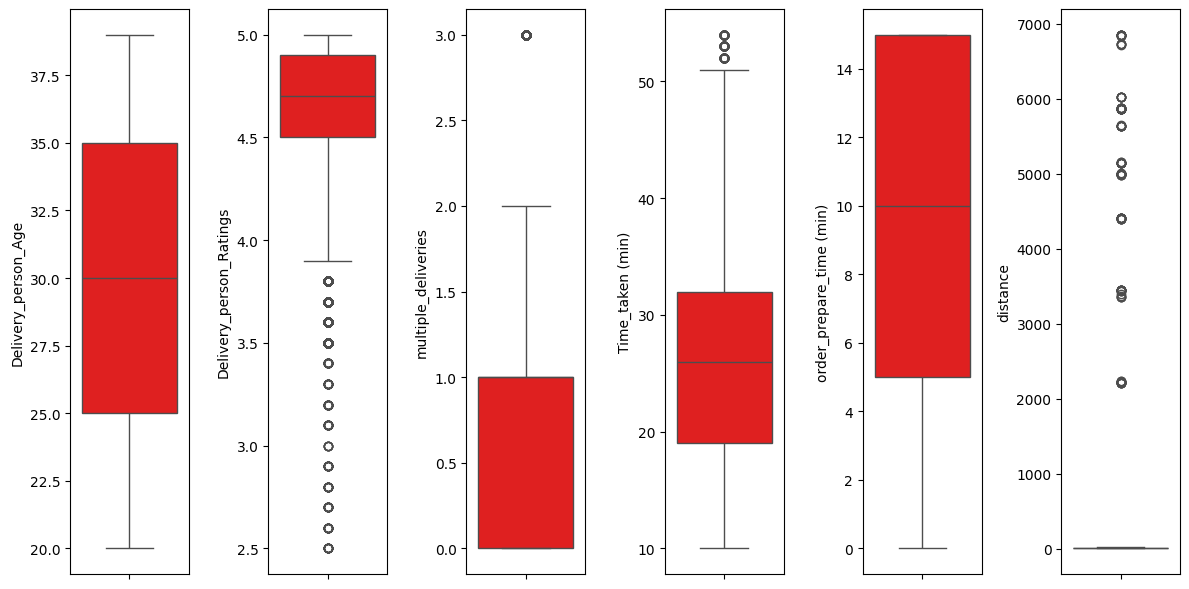

In [ ]:
# Identifikasi Outlier
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = numerical
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=deliv_df[features[i]], color='red')
    plt.tight_layout()

observasi:
Outlier pada `Delivery_person_Ratings` dan `multiple_deliveries` tidak akan didrop karena nilai masih make sense pada rentang Ratings dan Banyaknya Pesan. Untuk `distance` juga masih makes sense karena memungkinkan jika data jarak acak.

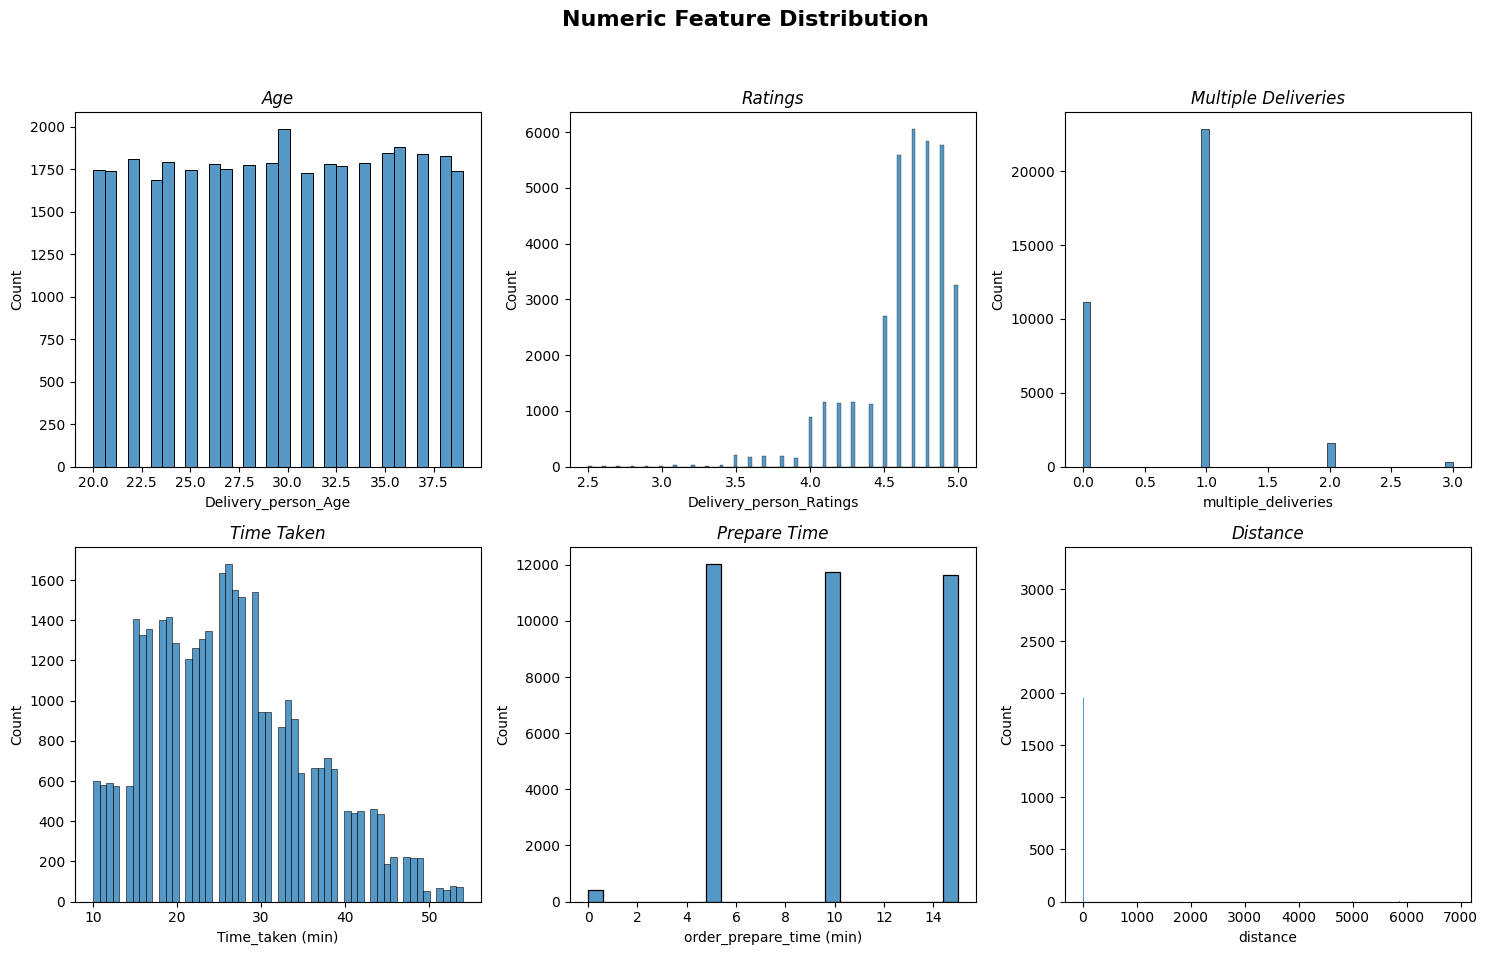

In [ ]:
# Visualisasi distribusi data numerik
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot masing-masing fitur
sns.histplot(deliv_df['Delivery_person_Age'], kde=False, ax=axes[0, 0]).set_title('Age', fontsize=12, fontstyle='italic')
sns.histplot(deliv_df['Delivery_person_Ratings'], kde=False, ax=axes[0, 1]).set_title('Ratings', fontsize=12, fontstyle='italic')
sns.histplot(deliv_df['multiple_deliveries'], kde=False, ax=axes[0, 2]).set_title('Multiple Deliveries', fontsize=12, fontstyle='italic')
sns.histplot(deliv_df['Time_taken (min)'], kde=False, ax=axes[1, 0]).set_title('Time Taken', fontsize=12, fontstyle='italic')
sns.histplot(deliv_df['order_prepare_time (min)'], kde=False, ax=axes[1, 1]).set_title('Prepare Time', fontsize=12, fontstyle='italic')
sns.histplot(deliv_df['distance'], kde=False, ax=axes[1, 2]).set_title('Distance', fontsize=12, fontstyle='italic')

# Menambahkan title untuk keseluruhan plot
plt.suptitle('Numeric Feature Distribution', fontsize=16, fontweight='bold', ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<ipython-input-37-197d90db1813>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'day_of_week', data = deliv_df,


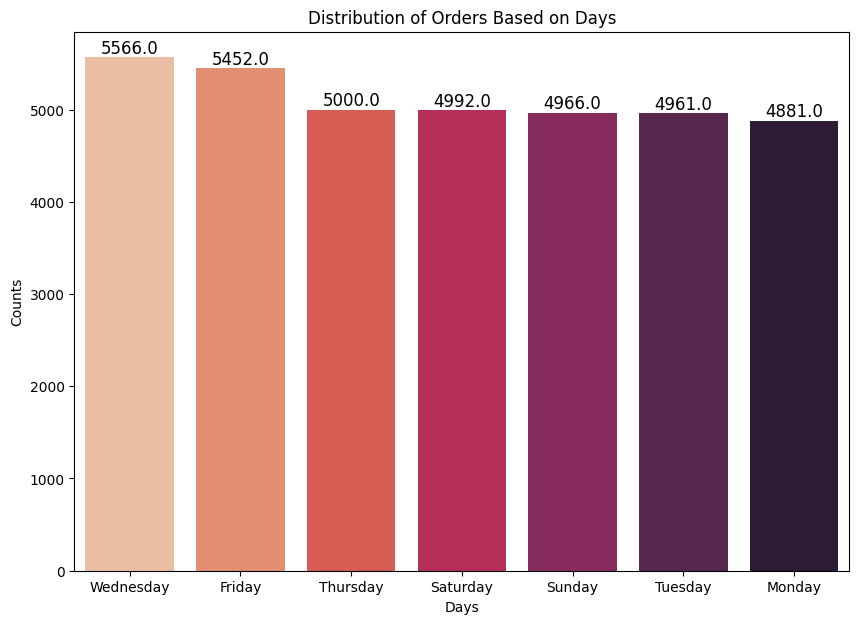

In [ ]:
# Customer Behaviour berdasarkan waktu pemesanan -> time_category & day_ofweek
fig, ax = plt.subplots(figsize=(10, 7))
# membuat plot
sns.countplot(x = 'day_of_week', data = deliv_df,
              order = deliv_df['day_of_week'].value_counts().iloc[:].index, palette='rocket_r')
# memunculkan angka/annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Tambahkan offset di sini
                ha='center', va='bottom', fontsize=12)

# menambahkan title dan label x dan label y
plt.title("Distribution of Orders Based on Days")
plt.xlabel('Days')
plt.ylabel('Counts')
plt.show()


<ipython-input-38-815279c17afc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'time_category', data = deliv_df,


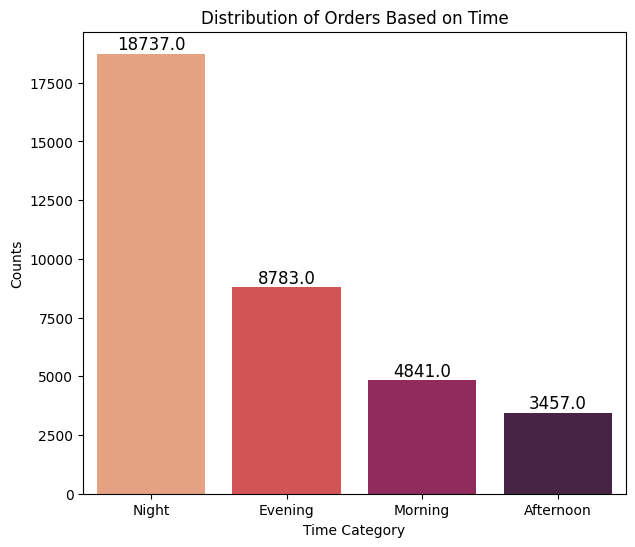

In [ ]:
# Customer Behaviour berdasarkan waktu pemesanan -> time_category & day_ofweek
fig, ax = plt.subplots(figsize=(7, 6))
# membuat plot
sns.countplot(x = 'time_category', data = deliv_df,
              order = deliv_df['time_category'].value_counts().iloc[:].index, palette='rocket_r')
# memunculkan angka/annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
# menambahkan title dan label x dan label y
plt.title("Distribution of Orders Based on Time")
plt.xlabel('Time Category')
plt.ylabel('Counts')
plt.show()

Obsertaviton: Most customers place orders at night

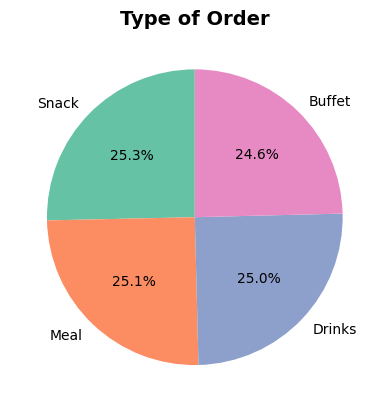

In [ ]:
# Customer Behaviour berdasar jenis pesanan -> type_of_order
# Mengelompokkan data dan menghitung type order
grouped_df = deliv_df['Type_of_order'].value_counts()
colors = sns.color_palette('Set2', len(grouped_df))

fig, ax = plt.subplots()
ax.pie(grouped_df, labels=grouped_df.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Menambahkan judul
ax.set_title('Type of Order', fontsize=14, fontweight='bold')

# Menampilkan chart
plt.show()

observasi: Tidak terdapat perbedaan yang signifikan terkait jenis pesanan yang dipesan customer.

## Bivariate Analysis

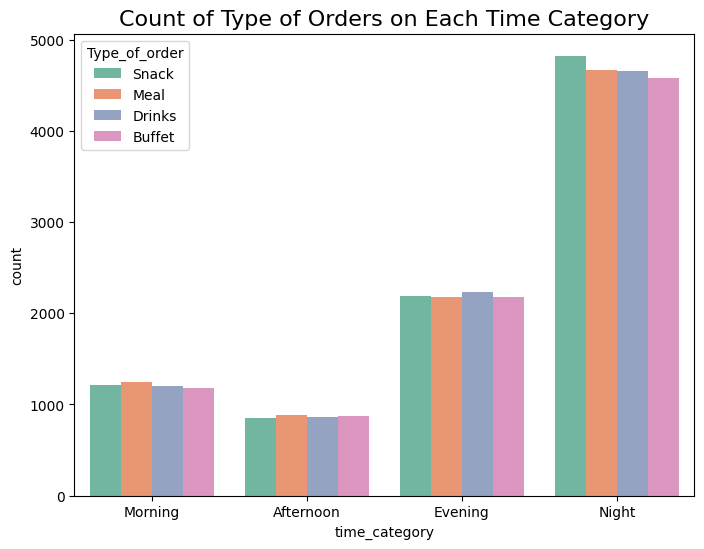

In [ ]:
# Time & Order
plt.figure(figsize=(8, 6))
sns.countplot(data=deliv_df,
            x='time_category',
            hue='Type_of_order', palette='Set2'
            )
plt.title('Count of Type of Orders on Each Time Category', fontsize=16)
plt.show()

<ipython-input-42-a6ba7c14411d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=deliv_df, x='time_category', y='Delivery_person_Ratings', ci=None, palette='Set2')
<ipython-input-42-a6ba7c14411d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=deliv_df, x='time_category', y='Delivery_person_Ratings', ci=None, palette='Set2')


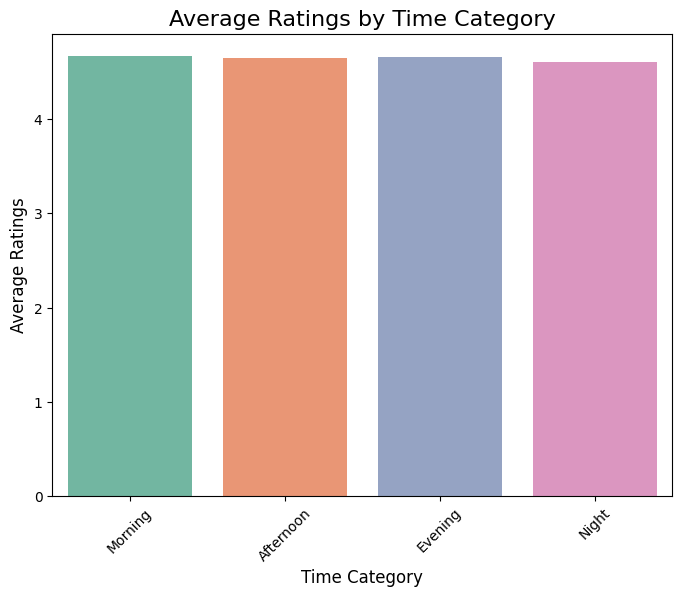

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=deliv_df, x='time_category', y='Delivery_person_Ratings', ci=None, palette='Set2')

# Menambahkan detail visual
plt.title('Average Ratings by Time Category', fontsize=16)
plt.xlabel('Time Category', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)
plt.xticks(rotation=45)

plt.show()

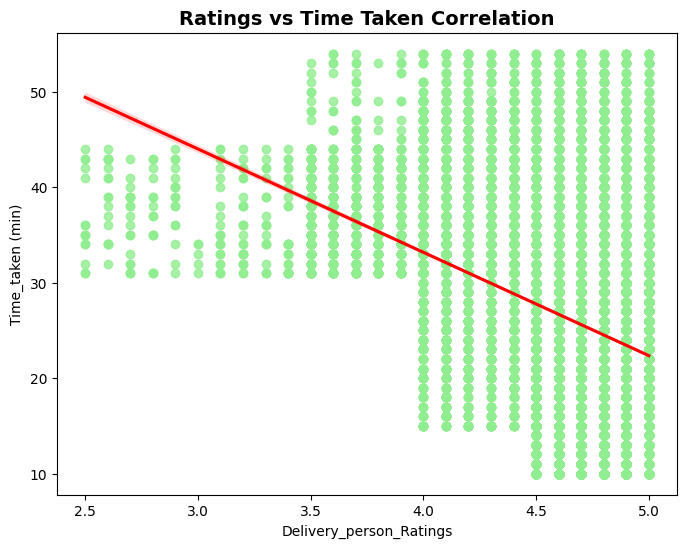

In [ ]:
# Ratings vs Time
plt.figure(figsize=(8, 6))
scatter_plot = sns.regplot(x='Delivery_person_Ratings', y='Time_taken (min)', data=deliv_df, scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})

# menambahkan judul
plt.title('Ratings vs Time Taken Correlation', fontsize=14, fontweight='bold')

# Menampilkan plot
plt.show()

<Axes: >

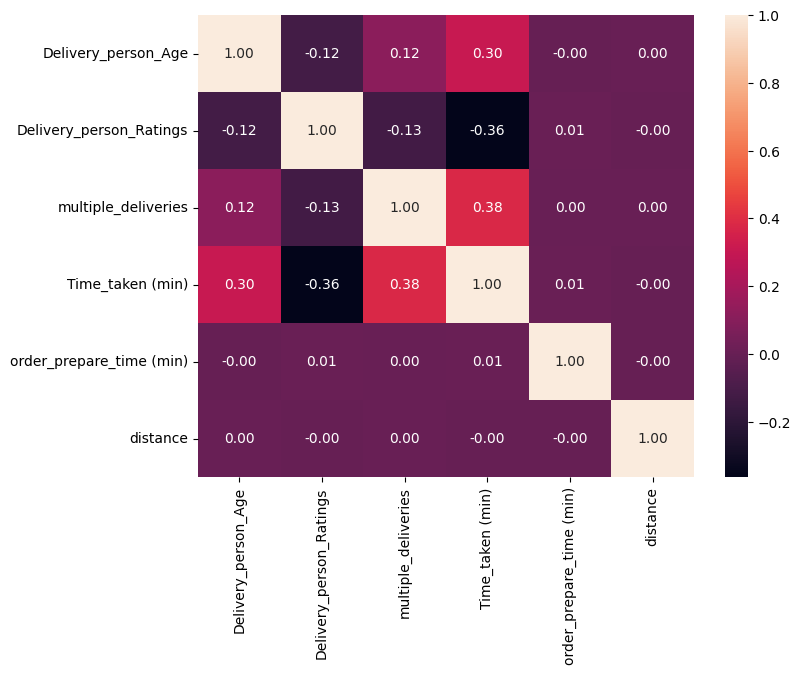

In [ ]:
# correlation heatmap untuk feature numerical
plt.figure(figsize=(8,6))
correlation = deliv_df[numerical].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

observasi:
* lamanya waktu pengantaran (Time_taken) berkorelasi positif dengan banyaknya pengantaran (multiple_deliveries), hal ini berarti bahwa semakin banyak jumlah orderan akan semakin lama waktu pengantaran.
* Rating berkorelasi negatif dengan time_taken, hal ini berarti bahwa semakin lama waktu pengantaran akan menghasilkan rating yang cenderung rendah

# Feature Engineering (After EDA)

In [ ]:
deliv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35818 entries, 0 to 45583
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Delivery_person_Age       35818 non-null  float64       
 1   Delivery_person_Ratings   35818 non-null  float64       
 2   Order_Date                35818 non-null  datetime64[ns]
 3   Weather_conditions        35818 non-null  object        
 4   Road_traffic_density      35818 non-null  object        
 5   Vehicle_condition         35818 non-null  int64         
 6   Type_of_order             35818 non-null  object        
 7   Type_of_vehicle           35818 non-null  object        
 8   multiple_deliveries       35818 non-null  float64       
 9   Festival                  35818 non-null  object        
 10  City                      35818 non-null  object        
 11  Time_taken (min)          35818 non-null  int64         
 12  order_prepare_time (min

In [ ]:
# sebelumnya akan dilakukan drop kolom Order_Date karena merupakan kolom unique yang kurang berpengaruh terhadap modeling
deliv_df = deliv_df.drop(columns=['Order_Date'])

## Scalling

Scalling dilakukan untuk features numerical --> Delivery_person_Age, Delivery_person_Rating, distance, Time_taken (min)

In [ ]:
b4_scale = deliv_df[['Delivery_person_Age','distance','Time_taken (min)','order_prepare_time (min)']]
b4_scale.head(10)

,Delivery_person_Age,distance,Time_taken (min),order_prepare_time (min)
0,36.0,10.271464,46,15
1,21.0,6.229376,23,10
2,23.0,13.764306,21,10
3,34.0,2.927795,20,10
4,24.0,19.373484,41,15
5,29.0,13.740932,20,10
6,35.0,6.205590,33,15
7,33.0,16.821192,40,10
8,34.0,10.738078,41,10
9,21.0,4.533896,15,15


In [ ]:
scaling = ['Delivery_person_Age','distance','Time_taken (min)','order_prepare_time (min)']
# Scaling dengan StandardScaler
for col in scaling:
  std_scaler = StandardScaler()
  deliv_df[col] = std_scaler.fit_transform(deliv_df[col].values.reshape(len(deliv_df), 1))



In [ ]:
after_scale = deliv_df[['Delivery_person_Age','distance','Time_taken (min)','order_prepare_time (min)']]
after_scale.head(10)

,Delivery_person_Age,distance,Time_taken (min),order_prepare_time (min)
0,1.116638,-0.055988,2.098577,1.231154
1,-1.491712,-0.069406,-0.351895,0.040296
2,-1.143932,-0.044393,-0.564979,0.040296
3,0.768858,-0.080366,-0.671521,0.040296
4,-0.970042,-0.025773,1.565866,1.231154
5,-0.100592,-0.044471,-0.671521,0.040296
6,0.942748,-0.069485,0.713528,1.231154
7,0.594968,-0.034245,1.459324,0.040296
8,0.768858,-0.054439,1.565866,0.040296
9,-1.491712,-0.075035,-1.204233,1.231154


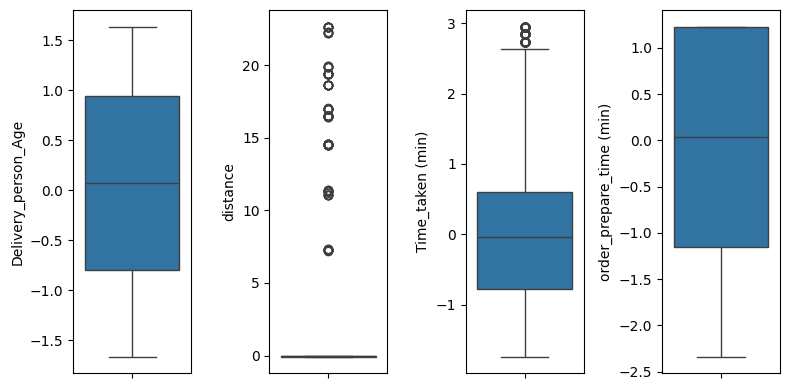

In [ ]:
Numeric = ['Delivery_person_Age','distance','Time_taken (min)','order_prepare_time (min)']

#Mengecek ulang
plt.figure(figsize=(8,4))
for i in range(0, len(Numeric)):
    plt.subplot(1, len(Numeric), i+1)
    sns.boxplot(y=deliv_df[Numeric[i]])
    plt.tight_layout()

## Encoding

* Label encoding dan Ordinal encoding: dilakukan untuk mengubah nilai categoric menjadi numeric yang terdapat hubungan hirarki --> Weather_conditions, Road_traffic_density, Festival, City, Type_of_vehicle (sudah numeric), dan day_of_week
* One hot encoding: dilakukan untuk features categorical yang tidak terdapat hubungan hirarki --> Type_of_order, time_category

### Label encoding & Ordinal encoding

In [ ]:
deliv_df['Festival'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
# Inisialisasi LabelEncoder
le = LabelEncoder()

# Fitur yang ingin di-encode
features_to_encode = ['Festival']

# Lakukan encoding untuk fitur
for feature in features_to_encode:
    deliv_df[feature] = le.fit_transform(deliv_df[feature])

In [ ]:
# Menggunakan map untuk ordinal encoding feature: Weather_conditions, Type of vehicle, Road_traffic_density, City, day of week
weather = {'Sunny' : 1, 'Cloudy' : 2, 'Windy' : 3, 'Fog' : 4, 'Sandstorms' : 5, 'Stormy' : 6}

vehicle = {'motorcycle' : 1, 'scooter' : 2, 'electric_scooter' : 3}

traffic = {'Low' : 1, 'Medium' : 2, 'High' : 3, 'Jam' : 4}

city = {'Metropolitian' : 1, 'Urban' : 2, 'Semi-Urban' : 3}

day = {'Monday': 1, 'Tuesday': 2,'Wednesday':3, 'Thursday': 5, 'Friday': 6,'Saturday': 7, 'Sunday': 8}

order = {'Buffet': 1, 'Drinks': 2, 'Meal':3, 'Snack':4}

time ={'Morning':1, 'Afternoon':2, 'Evening':3, 'Night':4}


In [ ]:
deliv_df['Weather_conditions'] = deliv_df['Weather_conditions'].map(weather)
deliv_df['Type_of_vehicle'] = deliv_df['Type_of_vehicle'].map(vehicle)
deliv_df['Road_traffic_density'] = deliv_df['Road_traffic_density'].map(traffic)
deliv_df['City'] = deliv_df['City'].map(city)
deliv_df['day_of_week'] = deliv_df['day_of_week'].map(day)
deliv_df['Type_of_order'] = deliv_df['Type_of_order'].map(order)
deliv_df['time_category'] = deliv_df['time_category'].map(time)

In [ ]:
deliv_df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),order_prepare_time (min),distance,time_category,day_of_week
0,1.116638,4.2,4,4,2,4,1,3.0,0,1,2.098577,1.231154,-0.055988,4,7
1,-1.491712,4.7,6,3,1,3,1,1.0,0,1,-0.351895,0.040296,-0.069406,2,8
2,-1.143932,4.7,5,2,1,2,2,1.0,0,1,-0.564979,0.040296,-0.044393,3,6
3,0.768858,4.3,5,1,0,1,1,0.0,0,1,-0.671521,0.040296,-0.080366,1,8
4,-0.970042,4.7,4,4,1,4,2,1.0,0,1,1.565866,1.231154,-0.025773,4,1


In [ ]:
deliv_df.isna().sum()

,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Weather_conditions,0
Road_traffic_density,0
Vehicle_condition,0
Type_of_order,0
Type_of_vehicle,0
multiple_deliveries,0
Festival,0
City,0


In [ ]:
deliv_df.dtypes

,0
Delivery_person_Age,float64
Delivery_person_Ratings,float64
Weather_conditions,int64
Road_traffic_density,int64
Vehicle_condition,int64
Type_of_order,int64
Type_of_vehicle,int64
multiple_deliveries,float64
Festival,int64
City,int64


Feature time_category memiliki data type category, perlu dilakukan pengubahan data type menjadi numerical

In [ ]:
deliv_df['time_category'] = deliv_df['time_category'].astype('int64')  # atau 'float64'


In [ ]:
deliv_df.dtypes

,0
Delivery_person_Age,float64
Delivery_person_Ratings,float64
Weather_conditions,int64
Road_traffic_density,int64
Vehicle_condition,int64
Type_of_order,int64
Type_of_vehicle,int64
multiple_deliveries,float64
Festival,int64
City,int64


semua kolom sudah numeric

# Machine Learning

## Split data: train-testing

In [ ]:
X = deliv_df.drop(columns='Delivery_person_Ratings')
y = deliv_df['Delivery_person_Ratings']

# splitting: train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # perbandingan 80:20


## VIF Score & Check Multicollinearity

In [ ]:
# membuat variabel untuk konstanta
kons = add_constant(X_train)
# menghitung nilai vif
vif_df = pd.DataFrame([vif(kons.values, i)
               for i in range(kons.shape[1])],
              index=kons.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Delivery_person_Age,1.139071
2,Weather_conditions,1.009244
3,Road_traffic_density,1.413167
4,Vehicle_condition,1.753528
5,Type_of_order,1.000205
6,Type_of_vehicle,1.658366
7,multiple_deliveries,1.169319
8,Festival,1.096476
9,City,1.022726
10,Time_taken (min),1.784972


observasi: tidak terdapat feature yang memiliki vif score tinggi (> 4), hal ini menunjukkan bahwa tidak terdapat multicollinierity antar feature dan model akan lebih stabil, sehingga tidak diperlukan treatment feature reduction.

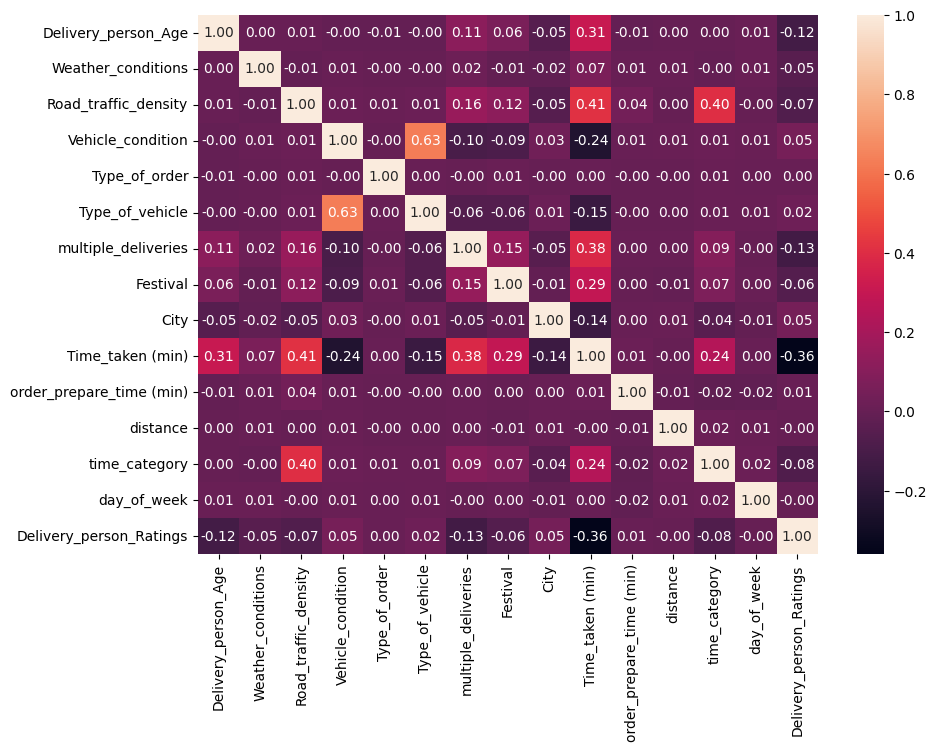

In [ ]:
# visualisasi heatmap correlation antar feature
rating_train = pd.concat([X_train, y_train], axis=1)
corr = rating_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

observasi:
* Ratings berkorelasi negatif dengan time taken.
* feature yang mempengaruhi tinggi nya time taken:
1. road_traffic_density: semakin padat lalu lintas menyebabkan waktu antar makin lama
2.  multiple_delivery: ketika driver mengambil lebih banyak order secara bersamaan, maka waktu antar akan semakin lama
3. age: terdapat korelasi positif -> semakin tua usia, waktu antar semakin lama
4. festival: ketika sedang ada festival, waktu antar semakin lama
5. time_category: semakin malam waktunya, semakin lama wakatu yang diperlukan untuk mengantar. Hal ini karena kepadatan lalulintas (traffic) cenderung lebih padat ketika malam, tercermin pada korelasi antar variabel traffic dan time_category


## Modelling

Pada project kali ini akan dilakukan modelling pada 4 jenis pemodelan: Lasso Regression, Ridge Regression, Random Forest Regression dan Xgboost

### Ridge Regression

In [ ]:
# Modelling
ridge = Ridge(alpha=0.01, random_state=42)
# Fitting the model
ridge.fit(X_train, y_train)

Ridge(alpha=0.01, random_state=42)

### Lasso

In [ ]:
# Modelling
lasso = Lasso(alpha=0.01, random_state=42)
# Fitting the model
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, random_state=42)

### Xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Random Forset Regressor

In [ ]:
# Fitting Random Forest Regression to the dataset
rf_reg = RandomForestRegressor(n_estimators=10, random_state=42, oob_score=True)
rf_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=42)

Modelling with Xgboost has smallest RMSE (error), so it's the better model among Ridge Regression, Lasso Regression and Random Forest Regression

## Model Evaluation

### Training Evaluation

Ridge Regression

In [ ]:
# Predict
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Evaluate - Training
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
mape_train_ridge = mean_absolute_percentage_error(y_train, y_train_pred_ridge)

Lasso Regression

In [ ]:
# Predict
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

# Evaluate - Training
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
mape_train_lasso = mean_absolute_percentage_error(y_train, y_train_pred_lasso)

Random Forest Regression

In [ ]:
# Predict
y_train_pred_rf = rf_reg.predict(X_train)
y_test_pred_rf = rf_reg.predict(X_test)

# Evaluate - Training
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)

Xgboost

In [ ]:
# Predict
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

# Evaluate - Training
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb)

### Testing Evaluation

In [ ]:
# Evaluate - Testing
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
mae_test_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
mape_test_ridge = mean_absolute_percentage_error(y_test, y_test_pred_ridge)

In [ ]:
# Evaluate - Testing
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
mae_test_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
mape_test_lasso = mean_absolute_percentage_error(y_test, y_test_pred_lasso)

In [ ]:
# Evaluate - Testing
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)

In [ ]:
# Evaluate - Testing
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
mape_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb)

### Result Metrics Evaluation

In [ ]:
results = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "Random Forest", "XGBoost"],
    "RMSE_Train": [rmse_train_ridge, rmse_train_lasso, rmse_train_rf, rmse_train_xgb],
    "RMSE_Test": [rmse_test_ridge, rmse_test_lasso, rmse_test_rf, rmse_test_xgb],
    "MAE_Train": [mae_train_ridge, mae_train_lasso, mae_train_rf, mae_train_xgb],
    "MAE_Test": [mae_test_ridge, mae_test_lasso, mae_test_rf, mae_test_xgb],
    "MAPE_Train": [mape_train_ridge, mape_train_lasso, mape_train_rf, mape_train_xgb],
    "MAPE_Test": [mape_test_ridge, mape_test_lasso, mape_test_rf, mape_test_xgb]
})
results

,Model,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,MAPE_Train,MAPE_Test
0,Ridge,0.291581,0.287060,0.216366,0.213096,0.049039,0.048273
1,Lasso,0.292949,0.288378,0.215502,0.212375,0.048950,0.048207
2,Random Forest,0.095166,0.225572,0.068450,0.177402,0.015112,0.039199
3,XGBoost,0.175447,0.218652,0.141727,0.174494,0.031132,0.038605


From 4 models, we can conclude that RandomForest Regression Model is the best model, The model has smallest error and experience increase in performance when implemented from training data to test data.
1. the standard deviation of prediction errors is 0.226, from the regression line, the residuals mostly deviate between +-0.226
2. on average, the prediction deviates the true ratings by 0.177
3. MAE 0.177 is equivalent to 1.5% deviation relative to the true rating

## Hyperparameter Turning

In [ ]:
parameters = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

rf_reg_gridcv = GridSearchCV(rf_reg, parameters, cv=5)
rf_reg_gridcv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=10, oob_score=True,
                                             random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5),
                         'n_estimators': (10, 20, 30, 40, 50)})

In [ ]:
# the results
cv_result = pd.DataFrame(rf_reg_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
20,"{'max_depth': 5, 'n_estimators': 10}",0.493689,1
21,"{'max_depth': 5, 'n_estimators': 20}",0.493640,2
24,"{'max_depth': 5, 'n_estimators': 50}",0.493585,3
23,"{'max_depth': 5, 'n_estimators': 40}",0.493484,4
22,"{'max_depth': 5, 'n_estimators': 30}",0.493393,5
18,"{'max_depth': 4, 'n_estimators': 40}",0.442693,6
19,"{'max_depth': 4, 'n_estimators': 50}",0.442683,7
17,"{'max_depth': 4, 'n_estimators': 30}",0.442417,8
16,"{'max_depth': 4, 'n_estimators': 20}",0.442062,9
15,"{'max_depth': 4, 'n_estimators': 10}",0.441474,10


In [ ]:
# Evaluate
y_pred_hp = rf_reg_gridcv.best_estimator_.predict(X_test)

rmse_test_rf_hp = np.sqrt(mean_squared_error(y_test, y_pred_hp))
mae_test_rf_hp = mean_absolute_error(y_test, y_pred_hp)
mape_test_rf_hp = mean_absolute_percentage_error(y_test, y_pred_hp)

print("RMSE after HP Tuning:", rmse_test_rf_hp)
print("MAE after HP Tuning:", mae_test_rf_hp)
print("MAPE after HP Tuning:", mape_test_rf_hp)

RMSE after HP Tuning: 0.2237320236068795
MAE after HP Tuning: 0.17873425008520064
MAPE after HP Tuning: 0.03963895732252672


In [ ]:
after_tuning = pd.DataFrame({
    "Metrics": ["RMSE","MAE","MAPE"],
    "Before Tuning": [rmse_test_rf, mae_test_rf, mape_test_rf],
    "After Tuning": [rmse_test_rf_hp, mae_test_rf_hp, mape_test_rf_hp ]
})
after_tuning

,Metrics,Before Tuning,After Tuning
0,RMSE,0.225572,0.223732
1,MAE,0.177402,0.178734
2,MAPE,0.039199,0.039639


## Feature Importance

In [ ]:
# Feature importances
importances = rf_reg.feature_importances_

# Tampilkan hasil
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


                     Feature  Importance
9           Time_taken (min)    0.278935
11                  distance    0.181777
1         Weather_conditions    0.175192
2       Road_traffic_density    0.079089
0        Delivery_person_Age    0.068899
3          Vehicle_condition    0.049068
13               day_of_week    0.045615
4              Type_of_order    0.030538
10  order_prepare_time (min)    0.024758
12             time_category    0.018905
6        multiple_deliveries    0.018730
5            Type_of_vehicle    0.013498
8                       City    0.011620
7                   Festival    0.003377


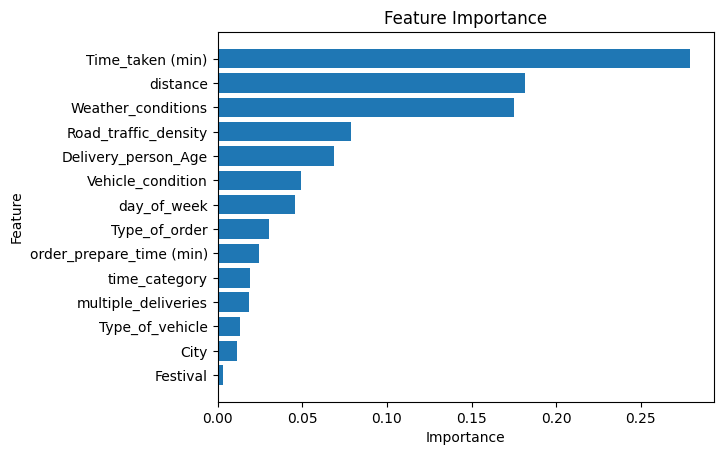

In [ ]:
# Visualisasi
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Membalik urutan fitur untuk tampilan yang lebih rapi
plt.show()

In [ ]:
!pip install dalex

In [ ]:
# Feature Importance Viz
import dalex as dx

In [ ]:
# import dalex to explain complex model
import dalex as dx

In [ ]:
## initiate explainer for Random Forest Reg model
deliv_rf_exp = dx.Explainer(rf_reg, X_train, y_train, label = "Random Forest Interpretation")

Preparation of a new explainer is initiated

  -> data              : 28654 rows 14 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28654 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Random Forest Interpretation
  -> predict function  : <function yhat_default at 0x7b351744d000> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.55, mean = 4.64, max = 5.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.57, mean = -7.29e-05, max = 0.58
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
# visualizr permutation feature importance for Random Forest Model
deliv_rf_exp.model_parts().plot()

Top 3 feature importance from RF Reg Model:
1. Time_taken
2. Weather_conditions
3. Vehicle_condition